In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from tqdm import tqdm_notebook
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import pdb

%matplotlib inline

In [11]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [23]:
class Gaussian():
    def __init__(self, mu, covar):
        self.distr = D.MultivariateNormal(loc=mu, covariance_matrix=covar)
        
    def get_logdensity(self, z):
        return self.distr.log_prob(z)
    
    def get_samples(self, N):
        return self.distr.sample((N, ))
    
mu = torch.tensor([10., 10.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)
target = Gaussian(mu,covar)

In [24]:
def HMC(current_z, x, epsilon, L): # U(z) = -logp(z,x)
    z = current_z
    r = torch.randn_like(z)
    current_r = r
    U = torch.mean(target.get_logdensity(z))
    r = r + 0.5 * epsilon * torch.autograd.grad(U, z)[0]
    for i in range(L):
        z = z + epsilon * r
        U = torch.mean(target.get_logdensity(z))
        if i!=L-1: r = r + epsilon * torch.autograd.grad(U, z)[0]
    
    current_U = target.get_logdensity(current_z)
    current_K = ((current_r**2) / 2).sum(1)
   
    proposed_U = target.get_logdensity(z)
    proposed_K = ((r**2) / 2).sum(1)
    
    z.detach()
    current_z.detach()
    
    # Metropolis
    u = D.uniform.Uniform(0,1).sample((batch_size,))
    zfilter = torch.ones(batch_size,2, device=device)
    for i in range(batch_size):
        if u[i] > torch.exp(current_U-proposed_U+current_K-proposed_K)[i]:
            zfilter[i] = 0.0
#     print(zfilter.sum())
    result = zfilter * z + (1-zfilter) * current_z
    return result

In [35]:
if __name__ == "__main__":
    batch_size=100
    true = nn.Parameter(target.get_samples(batch_size))
    approx = nn.Parameter(torch.zeros(batch_size,2))
    traj = torch.tensor([0.,0.]) # Starting point
    epsilon = torch.ones(2)
    M = 10 # Number of HMC iterations
    L = 100 # Number of leapfrog steps
    for i in range(M):
        approx = HMC(approx, true, epsilon, L)
        traj = torch.vstack((traj, approx.detach().mean(0)))
    traj = traj.numpy()

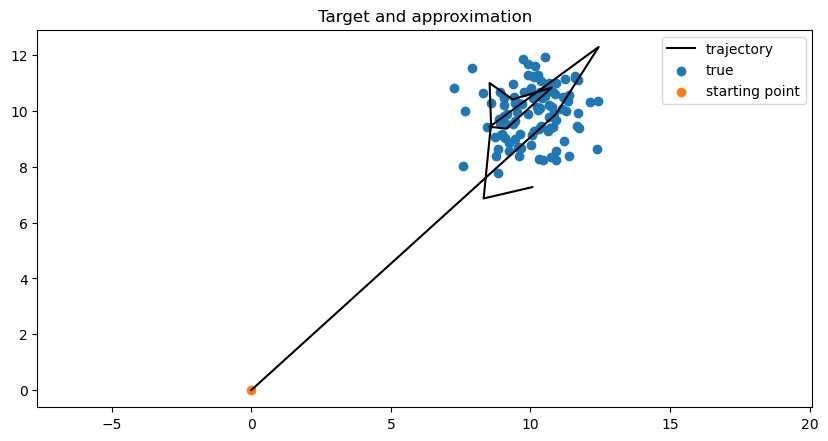

In [36]:
samples = true.detach().cpu().numpy()
# hmc = approx.detach().numpy()
# traj = traj.numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target and approximation')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1], label='true')
#plt.scatter(hmc[:, 0], hmc[:, 1], label='hmc')
plt.scatter(0,0,label='starting point')
plt.plot(traj[:,0], traj[:,1], label='trajectory', color='black')
plt.legend()
plt.show()